In [1]:
# imports
import pandas as pd
import os
import kagglehub
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy

# import kaggle 

In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# imports
import pandas as pd
# import os
# import kagglehub
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import scipy

# import kaggle 

In [4]:
import pickle

with open("edges_df_sorted.pk1", "rb") as f:
    edges_df_sorted = pickle.load(f)

with open("edges_df.pk1", "rb") as f:
    edges_df = pickle.load(f)
    
with open("df_aggregated.pk1", "rb") as f:
    df_aggregated = pickle.load(f)




In [5]:
edges_df

,Disease1,Disease2,Weight
0,abdominal aortic aneurysm,abdominal hernia,1
1,abdominal aortic aneurysm,abscess of the lung,1
2,abdominal aortic aneurysm,acute bronchiolitis,1
3,abdominal aortic aneurysm,acute bronchitis,1
4,abdominal aortic aneurysm,acute bronchospasm,1
...,...,...,...
66556,white blood cell disease,whooping cough,2
66557,white blood cell disease,wilson disease,1
66558,white blood cell disease,yeast infection,1
66559,whooping cough,wilson disease,1


In [6]:
G = nx.Graph()

for _, row in edges_df.iterrows():
    G.add_edge(row["Disease1"], row["Disease2"], weight=row["Weight"])


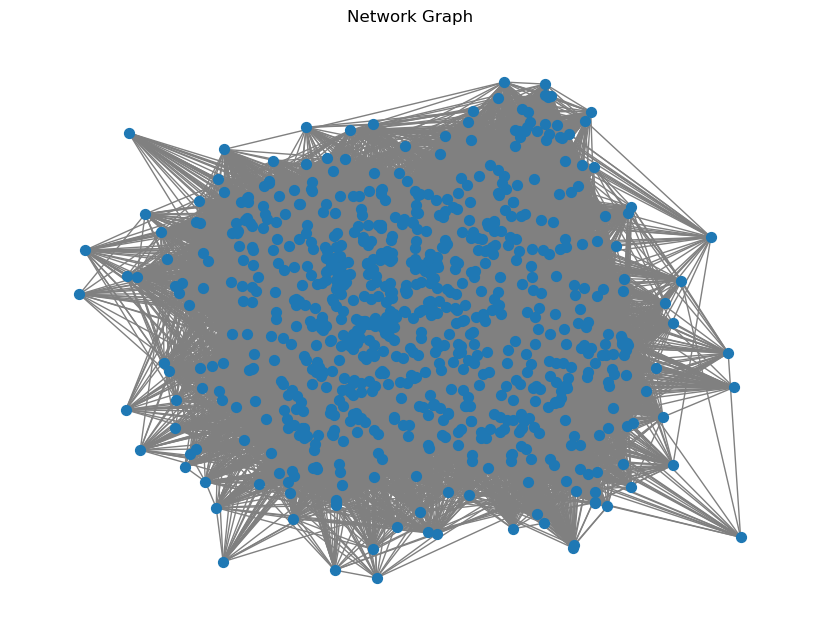

In [7]:
#https://medium.com/@dishasuyogi/link-prediction-3bd1a9a79f29

In [8]:
from networkx.algorithms.link_prediction import preferential_attachment

preds = list(preferential_attachment(G))
sorted_preds = sorted(preds, key=lambda x: x[2], reverse=True)[:10]
print("Top 10 predicted disease connections (Preferential Attachment):", sorted_preds)

#returns unconnected nodes (just how preferential_attachment function works)
#score is based on the degrees of both diseases multiplied together
#high likelihood that they may share common symptoms, even if they aren't directly observed yet, so they should be further invested






Top 10 predicted disease connections (Preferential Attachment): [('drug reaction', 'lymphadenitis', 137984), ('shingles (herpes zoster)', 'lymphadenitis', 133408), ('sepsis', 'shingles (herpes zoster)', 133029), ('acute stress reaction', 'lymphadenitis', 132352), ('lyme disease', 'acute kidney injury', 131019), ('lyme disease', 'pleural effusion', 128877), ('lyme disease', 'esophagitis', 126735), ('pleural effusion', 'intracranial hemorrhage', 126711), ('lyme disease', 'hyponatremia', 125664), ('lymphadenitis', 'intracerebral hemorrhage', 124960)]


In [11]:
#sanity check 
predicted_pairs = [
    ('drug reaction', 'lymphadenitis'),
    ('shingles (herpes zoster)', 'lymphadenitis'),
    ('sepsis', 'shingles (herpes zoster)'),
    ('acute stress reaction', 'lymphadenitis'),
    ('lyme disease', 'acute kidney injury'),
    ('lyme disease', 'pleural effusion'),
    ('lyme disease', 'esophagitis'),
    ('pleural effusion', 'intracranial hemorrhage'),
    ('lyme disease', 'hyponatremia'),
    ('lymphadenitis', 'intracerebral hemorrhage')
]

for u, v in predicted_pairs:
    if G.has_edge(u, v):
        print(f"Already connected: {u} — {v}")
    else:
        print(f"Not connected (valid prediction): {u} — {v}")


Not connected (valid prediction): drug reaction — lymphadenitis
Not connected (valid prediction): shingles (herpes zoster) — lymphadenitis
Not connected (valid prediction): sepsis — shingles (herpes zoster)
Not connected (valid prediction): acute stress reaction — lymphadenitis
Not connected (valid prediction): lyme disease — acute kidney injury
Not connected (valid prediction): lyme disease — pleural effusion
Not connected (valid prediction): lyme disease — esophagitis
Not connected (valid prediction): pleural effusion — intracranial hemorrhage
Not connected (valid prediction): lyme disease — hyponatremia
Not connected (valid prediction): lymphadenitis — intracerebral hemorrhage


In [10]:
betweenness = nx.betweenness_centrality(G)

def cn_ex_score(G, u, v):
    common_neighbors = set(G.neighbors(u)).intersection(G.neighbors(v))
    return sum(betweenness[w] for w in common_neighbors)

#make sure it's applying to non edges
preds = [(u, v, cn_ex_score(G, u, v)) for u, v in nx.non_edges(G)]
sorted_preds = sorted(preds, key=lambda x: x[2], reverse=True)[:10]
print("Top 10 predicted disease connections (Common Neighbor Expansion):", sorted_preds)

#high betweenness would be like a bridge right, and it connects clusters of seperate diseases
#idea is that two diseases are likely connected if they share neighbours that act as important bridges in the network

#so we are looking at pair of diseases that are not currently connected, and we look at their common neighybours, and just sums the betweenness centrality scores of the common neighbours
#nodes that are acting as bridges or hubs could contribute to two diseases being related
#ex: drug reaction and lymphadenitis have common neighbours
#score is based on the sum of the betweenness centrality scores in the common neighbours

Top 10 predicted disease connections (Common Neighbor Expansion): [('drug reaction', 'lymphadenitis', 0.3481996270888205), ('smoking or tobacco addiction', 'persistent vomiting of unknown cause', 0.34366988802055937), ('pleural effusion', 'headache after lumbar puncture', 0.34255645619346653), ('flu', 'thoracic aortic aneurysm', 0.33254357732185696), ('persistent vomiting of unknown cause', 'sarcoidosis', 0.3323469763190164), ('pleural effusion', 'labyrinthitis', 0.3315912379189222), ('pleural effusion', 'carbon monoxide poisoning', 0.3309285068080919), ('strep throat', 'thoracic aortic aneurysm', 0.3301448438760564), ('smoking or tobacco addiction', 'hypovolemia', 0.32974835972496097), ('sepsis', 'shingles (herpes zoster)', 0.3286918974276294)]


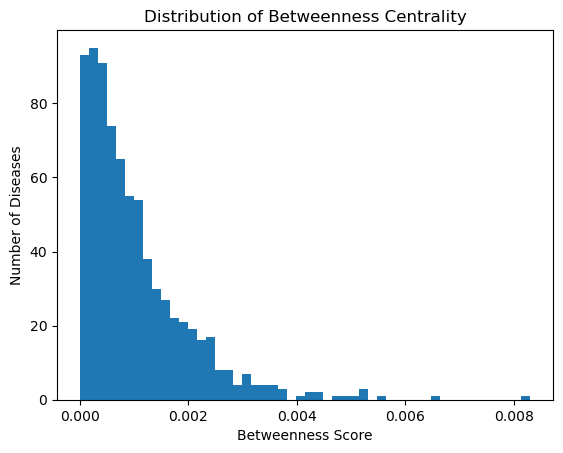

In [12]:
#wanted to see why the scores seemed kinda low
import matplotlib.pyplot as plt

plt.hist(betweenness.values(), bins=50)
plt.title("Distribution of Betweenness Centrality")
plt.xlabel("Betweenness Score")
plt.ylabel("Number of Diseases")
plt.show()


In [15]:
from networkx.algorithms.link_prediction import jaccard_coefficient

jaccard_preds = list(jaccard_coefficient(G))

top_10_jaccard = sorted(jaccard_preds, key=lambda x: x[2], reverse=True)[:10]

print("Top 10 Predicted Disease Links (Jaccard Coefficient):\n")
for u, v, score in top_10_jaccard:
    print(f"{u} — {v}: {score:.4f}")

#jaccards works on non-links

#sort so that for each x in the list, use the third element (which is the score) as the key to sort by


Top 10 Predicted Disease Links (Jaccard Coefficient):

aplastic anemia — foreign body in the throat: 0.4661
friedrich ataxia — tonsillitis: 0.4620
aplastic anemia — whooping cough: 0.4524
alcohol withdrawal — narcolepsy: 0.4500
pleural effusion — headache after lumbar puncture: 0.4420
smoking or tobacco addiction — hypoglycemia: 0.4414
lactose intolerance — achalasia: 0.4413
hemolytic anemia — erythema multiforme: 0.4410
drug reaction — lymphadenitis: 0.4391
hirsutism — open wound from surgical incision: 0.4224


In [16]:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.adamic_adar_index.html

from networkx.algorithms.link_prediction import adamic_adar_index

aa_preds = list(adamic_adar_index(G))

top_10_aa = sorted(aa_preds, key=lambda x: x[2], reverse=True)[:10]

print("Top 10 Predicted Disease Links (Adamic-Adar Index):\n")
for u, v, score in top_10_aa:
    print(f"{u} — {v}: {score:.4f}")


Top 10 Predicted Disease Links (Adamic-Adar Index):

drug reaction — lymphadenitis: 41.9591
pleural effusion — headache after lumbar puncture: 36.5498
shingles (herpes zoster) — lymphadenitis: 36.3356
smoking or tobacco addiction — hypoglycemia: 36.0910
pleural effusion — labyrinthitis: 34.8218
smoking or tobacco addiction — hypovolemia: 34.7543
smoking or tobacco addiction — persistent vomiting of unknown cause: 34.6091
pleural effusion — carbon monoxide poisoning: 34.0477
persistent vomiting of unknown cause — sarcoidosis: 33.4763
alcohol withdrawal — narcolepsy: 33.0086


In [8]:
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.cn_soundarajan_hopcroft.html


